# Análise exploratória dos dados

In [94]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.special import boxcox as special_boxcox
from scipy.stats import boxcox as stats_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho padrão das figuras

import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [16]:
df_load = pd.read_csv("daily_load.csv", parse_dates = ["date"])

In [17]:
df_load.head() # load_mwmed: carga própria de energia

,id_reg,desc_reg,date,load_mwmed
0,N,NORTE,2000-01-01,2243.512500
1,NE,NORDESTE,2000-01-01,4646.370833
2,S,SUL,2000-01-01,4800.650000
3,SE,SUDESTE,2000-01-01,19045.995833
4,N,NORTE,2000-01-02,2259.808333


In [18]:
df_load_sul = df_load[df_load["id_reg"] == "S"].reset_index(drop = True) # filtro para a região sul

In [19]:
dt_min = df_load_sul.date.min()
dt_max = df_load_sul.date.max()

print(f"Data mínima: {dt_min}")
print(f"Data máxia: {dt_max}")

Data mínima: 2000-01-01 00:00:00
Data máxia: 2022-06-23 00:00:00


In [20]:
df_load_sul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8211 entries, 0 to 8210
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_reg      8211 non-null   object        
 1   desc_reg    8211 non-null   object        
 2   date        8211 non-null   datetime64[ns]
 3   load_mwmed  8197 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 256.7+ KB


In [7]:
# VALORES FALTANTES
df_load_sul.isna().sum() 

id_reg         0
desc_reg       0
date           0
load_mwmed    14
dtype: int64

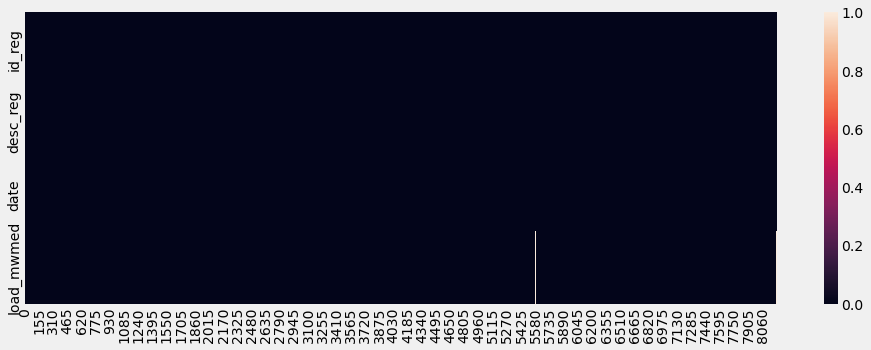

In [28]:
sns.heatmap(df_load_sul.isna().transpose()) 
plt.show()

In [29]:
# PREENCHENDO VALORES VAZIOS
df_load_sul.sort_values(by = "date", inplace = True)
df_load_sul["load_mwmed"].interpolate(inplace = True) 

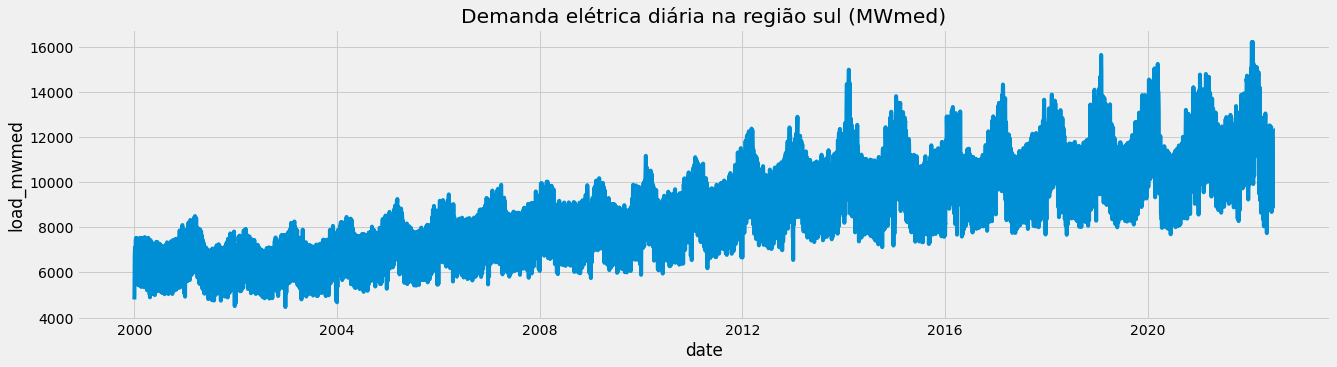

In [30]:
plt.figure(figsize = (20, 5))

sns.lineplot(x = "date", y = "load_mwmed", data = df_load_sul)

plt.title("Demanda elétrica diária na região sul (MWmed)")

plt.show()

In [10]:
fig = px.scatter(df_load_sul, x = "date", y = "load_mwmed", 
                labels=dict(date="Data", load_mwmed="Carga de energia (MWmed)"),
                template = 'plotly_dark'
                )

fig.show()

In [31]:
# CRIANDO VARIÁVEIS DE CALENDÁRIO
df_load_sul["ano"] = df_load_sul.date.dt.year
df_load_sul["trimestre"] = df_load_sul.date.dt.quarter
df_load_sul["mes"] = df_load_sul.date.dt.month
df_load_sul["dia"] = df_load_sul.date.dt.day
df_load_sul["dia_ano"] = df_load_sul.date.dt.dayofyear
df_load_sul["dia_semana"] = df_load_sul.date.dt.weekday + 1    # 1: segunda-feira; 7: domingo
df_load_sul["semana_ano"] = df_load_sul.date.dt.isocalendar().week
df_load_sul["apagao"] = df_load_sul.date.dt.year.apply(lambda x: 1 if x in [2001, 2002] else 0) # apagão de 2001 e 2002
df_load_sul.head()

,id_reg,desc_reg,date,load_mwmed,ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,apagao
0,S,SUL,2000-01-01,4800.650000,2000,1,1,1,1,6,52,0
1,S,SUL,2000-01-02,4899.800000,2000,1,1,2,2,7,52,0
2,S,SUL,2000-01-03,6261.554167,2000,1,1,3,3,1,1,0
3,S,SUL,2000-01-04,6733.741667,2000,1,1,4,4,2,1,0
4,S,SUL,2000-01-05,6961.170833,2000,1,1,5,5,3,1,0


In [32]:
df_load_sul.describe()

,load_mwmed,ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,apagao
count,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000,8211.000000
mean,9226.544107,2010.743637,2.486542,6.456095,15.716356,181.091706,4.000122,26.306784,0.088905
std,2129.426211,6.492002,1.117531,3.450307,8.797730,105.493737,2.000213,15.075564,0.284624
min,4465.691251,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,7518.079792,2005.000000,1.000000,3.000000,8.000000,90.000000,2.000000,13.000000,0.000000
50%,8998.524542,2011.000000,2.000000,6.000000,16.000000,179.000000,4.000000,26.000000,0.000000
75%,10885.846979,2016.000000,3.000000,9.000000,23.000000,272.000000,6.000000,39.000000,0.000000
max,16219.351042,2022.000000,4.000000,12.000000,31.000000,366.000000,7.000000,53.000000,1.000000


In [33]:
df_load_sul_2021 = df_load_sul[df_load_sul["ano"] == 2021]

fig = px.line(df_load_sul_2021, x = "date", y = "load_mwmed", title = "Demanda elétrica diária na região sul - 2021 (MWmed)")

fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)'
})

fig.show()

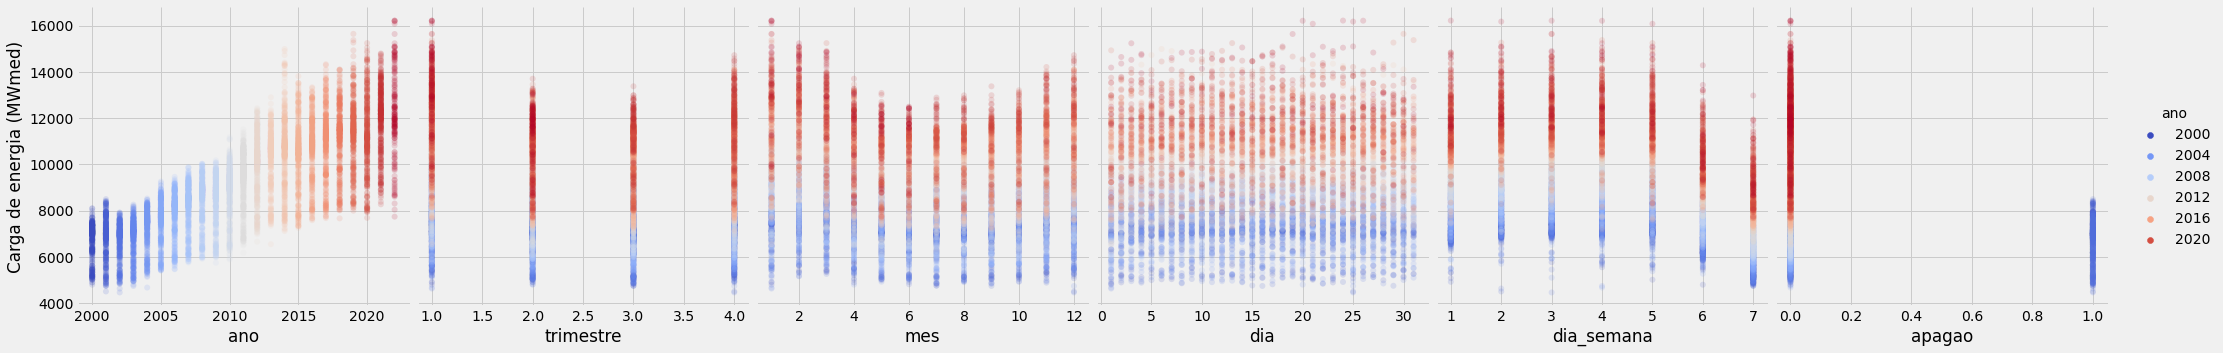

In [34]:
g = sns.pairplot(df_load_sul, 
             hue = "ano", 
             x_vars = [ "ano", "trimestre", "mes", "dia", "dia_semana", "apagao"],
             y_vars = "load_mwmed",
             height = 5,
             plot_kws={'alpha':0.15, 'linewidth':0, 'palette': 'coolwarm'})

g.axes.flat[0].set_ylabel("Carga de energia (MWmed)")

plt.show()

In [42]:
df_load_sul2 = df_load_sul[["date", "load_mwmed"]].set_index("date")
df_load_sul2 = df_load_sul2.asfreq('d')

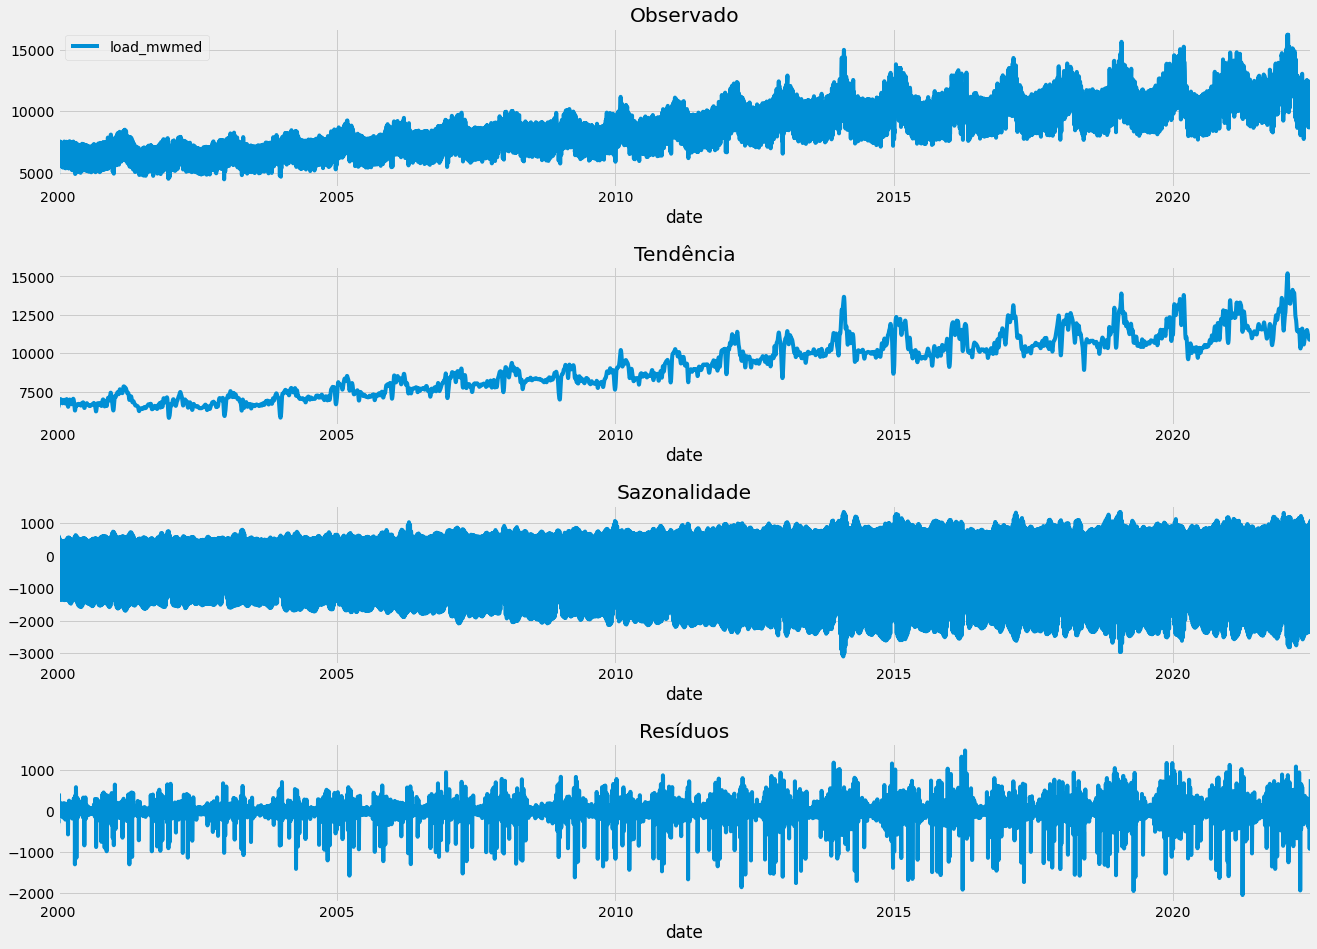

In [43]:
# STL
from statsmodels.tsa.seasonal import STL

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (20,15))
decompose_data = STL(df_load_sul2, seasonal = 7)
decompose_data = decompose_data.fit()

decompose_data.observed.plot(ax = ax1, title = "Observado")
decompose_data.trend.plot(ax = ax2, title = "Tendência")
decompose_data.seasonal.plot(ax = ax3, title = "Sazonalidade")
decompose_data.resid.plot(ax = ax4, title = "Resíduos")

plt.subplots_adjust(hspace= 0.5)
plt.show()

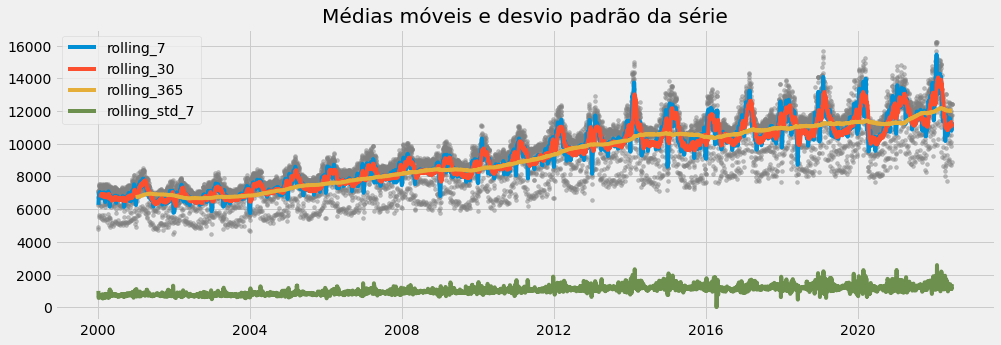

In [62]:
# MÉDIAS MÓVEIS
wdws = [7, 30, 365]
rolling_window_columns = []
for wdw in wdws:
    col = "rolling_" + str(wdw)
    rolling_window_columns.append(col)
    df_load_sul[col] = df_load_sul["load_mwmed"].rolling(wdw).mean()
    
plt.scatter(df_load_sul["date"], df_load_sul["load_mwmed"], alpha=.5, c = "gray", s = 15)
for rw in rolling_window_columns:
    plt.plot(df_load_sul["date"], df_load_sul[rw], label = rw)

plt.plot(df_load_sul["date"], df_load_sul["load_mwmed"].rolling(7).std(), label = "rolling_std_7")

plt.title(f"Médias móveis e desvio padrão da série")
plt.legend()

plt.show()

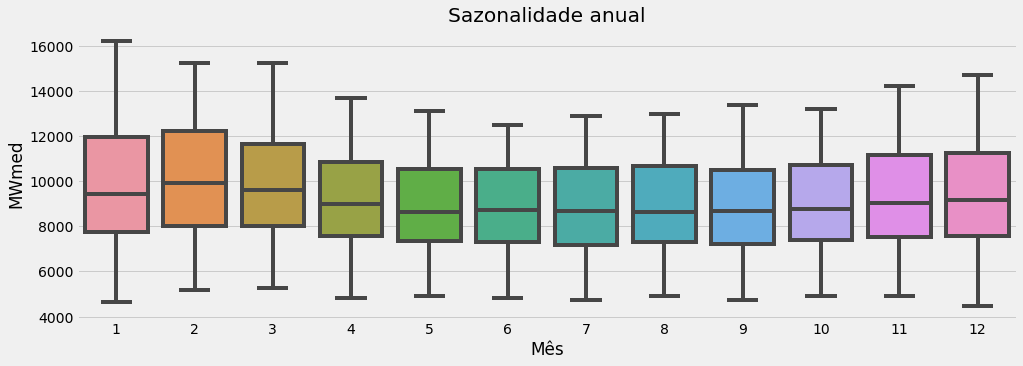

In [46]:
# SAZONALIDADE ANUAL
sns.boxplot(df_load_sul["mes"], df_load_sul["load_mwmed"])

plt.title("Sazonalidade anual")
plt.ylabel("MWmed")
plt.xlabel("Mês")

plt.show()

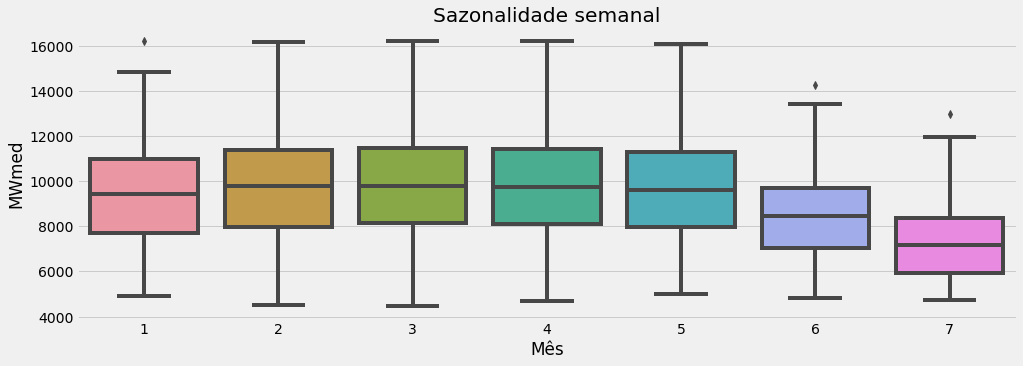

In [48]:
# SAZONALIDADE SEMANAL
sns.boxplot(df_load_sul["dia_semana"], df_load_sul["load_mwmed"])

plt.title("Sazonalidade semanal")
plt.ylabel("MWmed")
plt.xlabel("Mês")

plt.show()

### Autocorrelação

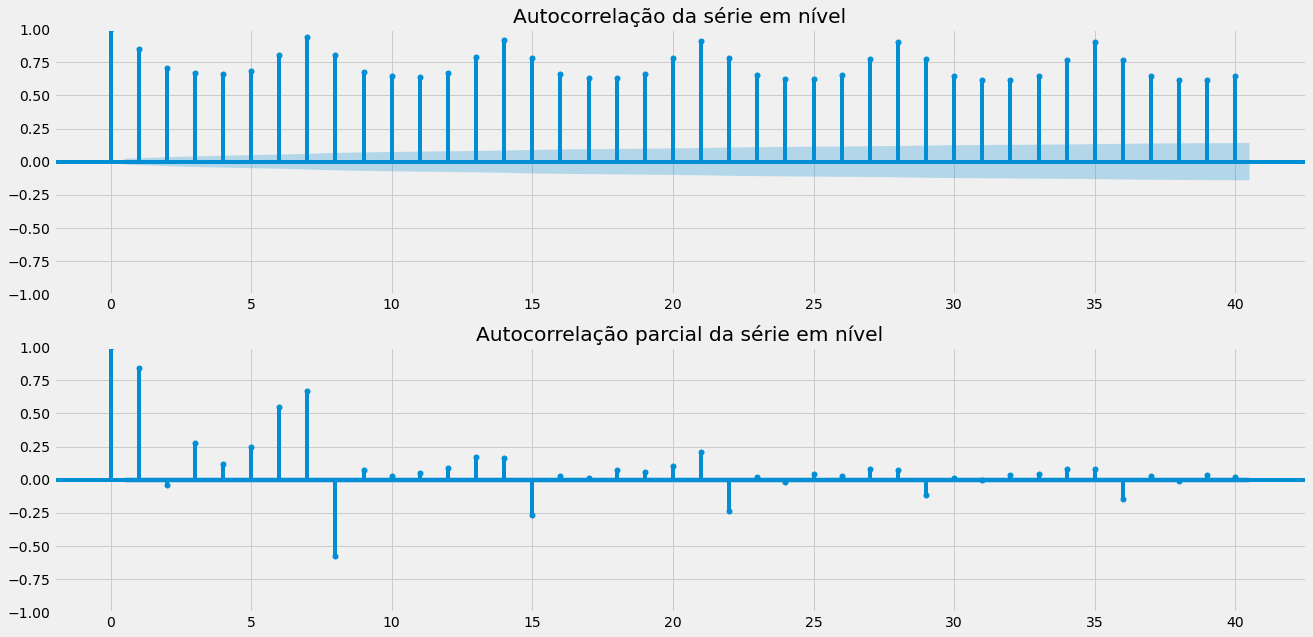

In [92]:
N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul["load_mwmed"], title = "Autocorrelação da série em nível", ax = ax1)
plot_pacf(df_load_sul["load_mwmed"], title = "Autocorrelação parcial da série em nível", ax = ax2)
plt.show()

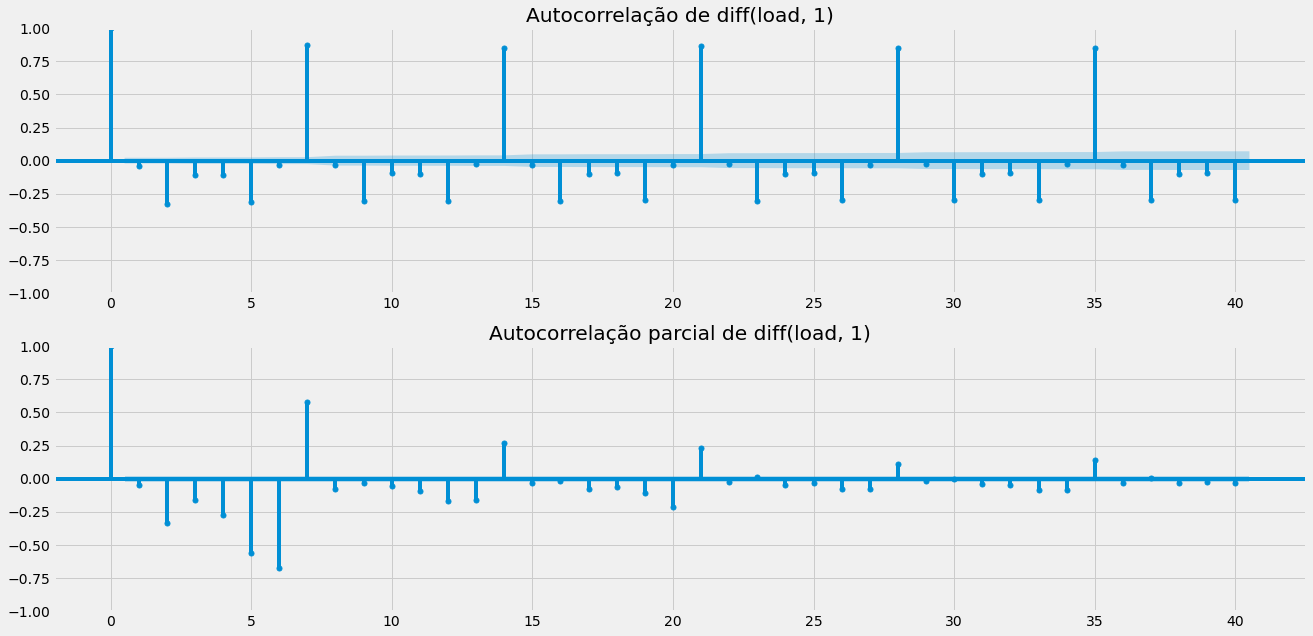

In [87]:
df_load_sul_diff1 = df_load_sul["load_mwmed"].diff().dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1, title = "Autocorrelação de diff(load, 1)", ax = ax1)
plot_pacf(df_load_sul_diff1, title = "Autocorrelação parcial de diff(load, 1)", ax = ax2)
plt.show()

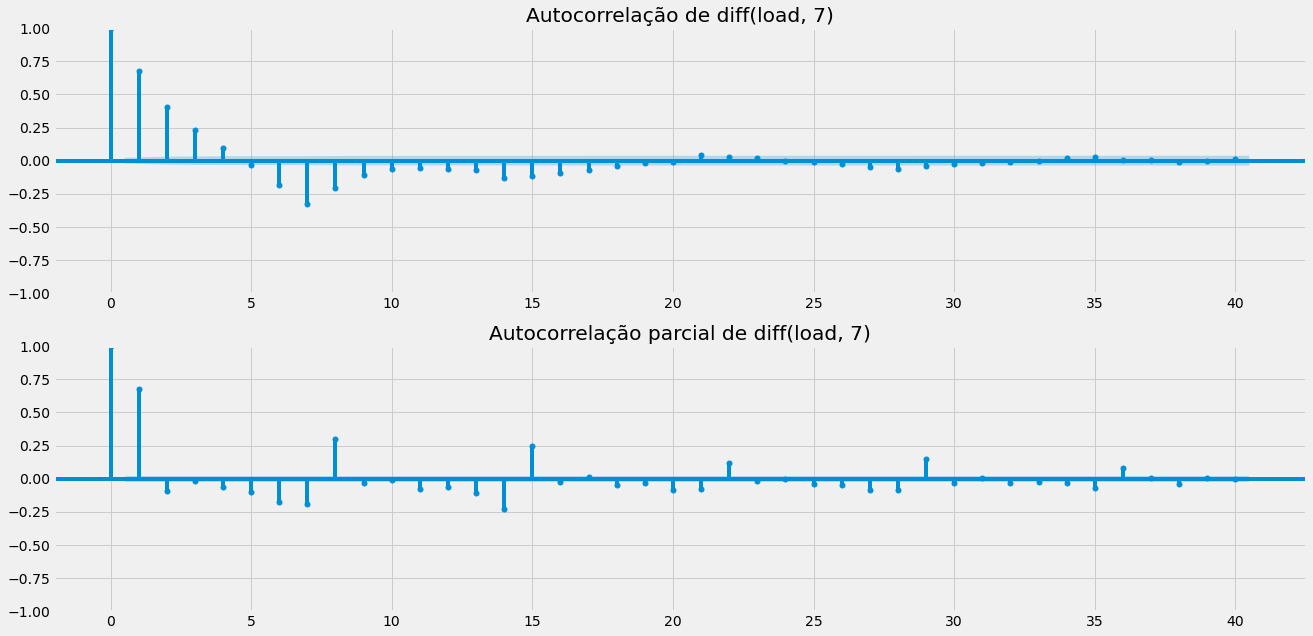

In [90]:
df_load_sul_diff7 = df_load_sul["load_mwmed"].diff(7).dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff7, title = "Autocorrelação de diff(load, 7)", ax = ax1)
plot_pacf(df_load_sul_diff7, title = "Autocorrelação parcial de diff(load, 7)", ax = ax2)
plt.show()

### Transformações

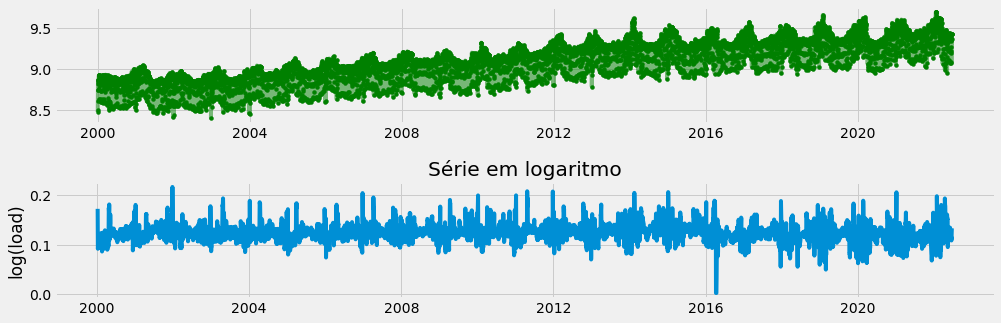

In [78]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,5))

df_load_sul_log = np.log(df_load_sul["load_mwmed"])

ax1.scatter(df_load_sul["date"], df_load_sul_log, c = "green", s = 15)
ax1.plot(df_load_sul["date"], df_load_sul_log, alpha = .5, c = "green")
ax2.plot(df_load_sul["date"], df_load_sul_log.rolling(7).std(), label = "rolling_std_7")

plt.subplots_adjust(hspace= 0.5)
plt.title(f"Série em logaritmo")
plt.ylabel("log(load)")

plt.show()

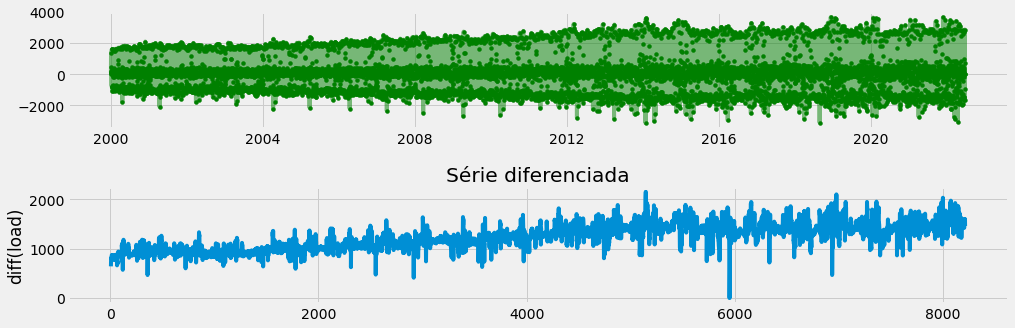

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,5))

df_load_sul_diff = df_load_sul["load_mwmed"].diff()

ax1.scatter(df_load_sul["date"], df_load_sul_diff, c = "green", s = 15)
ax1.plot(df_load_sul["date"], df_load_sul_diff, alpha=.5, c = "green")
ax2.plot(df_load_sul_diff.dropna().rolling(7).std(), label = "rolling_std_7")

plt.subplots_adjust(hspace= 0.5)
plt.title(f"Série diferenciada")
plt.ylabel("diff(load)")

plt.show()

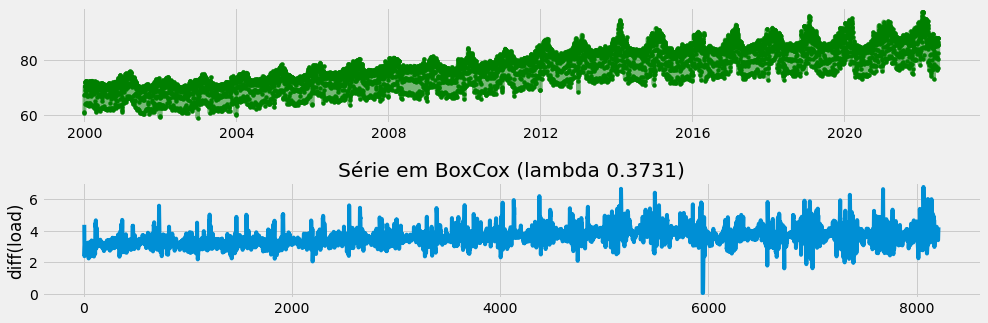

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15,5))

sbcx = stats_boxcox(df_load_sul.load_mwmed)
bcx = sbcx[0]
lambda_ = sbcx[1]

ax1.scatter(df_load_sul["date"], special_boxcox(df_load_sul["load_mwmed"], lambda_), c = "green", s = 15)
ax1.plot(df_load_sul["date"], special_boxcox(df_load_sul["load_mwmed"], lambda_), alpha=.5, c = "green")
ax2.plot(special_boxcox(df_load_sul["load_mwmed"], lambda_).rolling(7).std())

plt.subplots_adjust(hspace= 0.5)
plt.title(f"Série em BoxCox (lambda {round(lambda_, 4)})")
plt.ylabel("diff(load)")

plt.show()

## Estacionariedade

In [109]:
result = adfuller(df_load_sul["load_mwmed"])
print('P-valor da série em nível: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série em nível: 0.109747
Estatística ADF: -2.523987
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [97]:
result = adfuller(df_load_sul_log)
print('P-valor da série em logaritmo: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série em logaritmo: 0.175803
Estatística ADF: -2.288196
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [98]:
result = adfuller(df_load_sul_diff1)
print('P-valor da série diferenciada: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série diferenciada: 0.000000
Estatística ADF: -20.616684
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Distribuição

In [77]:
# Transformações
x_norm = (df_load_sul["load_mwmed"] - df_load_sul["load_mwmed"].mean())/df_load_sul["load_mwmed"].std()
x_log = np.log(df_load_sul["load_mwmed"])
x_boxcox_1 = stats_boxcox(df_load_sul["load_mwmed"]) 
lambda_ = 2.5
x_boxcox_2 = special_boxcox(df_load_sul["load_mwmed"], lambda_)
x_diff = df_load_sul["load_mwmed"].diff()

series = {
        "Nível": df_load_sul["load_mwmed"],
        "(x - x̅)/σ": x_norm,
        "Logaritmo": x_log,
        f"Boxcox (lambda {x_boxcox_1[1]})": x_boxcox_1[0], #?stats_boxcox # [0] = série; [1] = lamba que maximiza função de máxima verossimilhança
        f"Boxcox (lambda {lambda_})": x_boxcox_2,
        "Série diferenciada": x_diff
        }

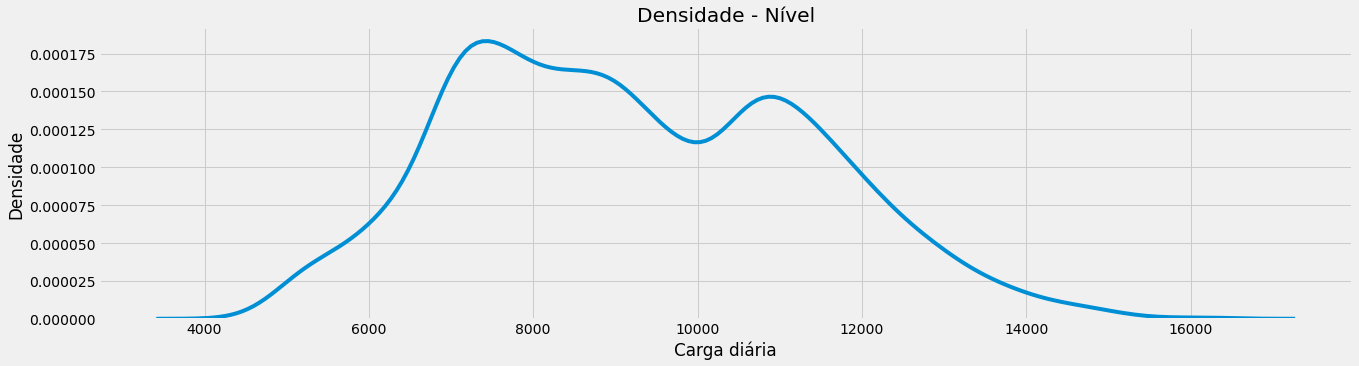

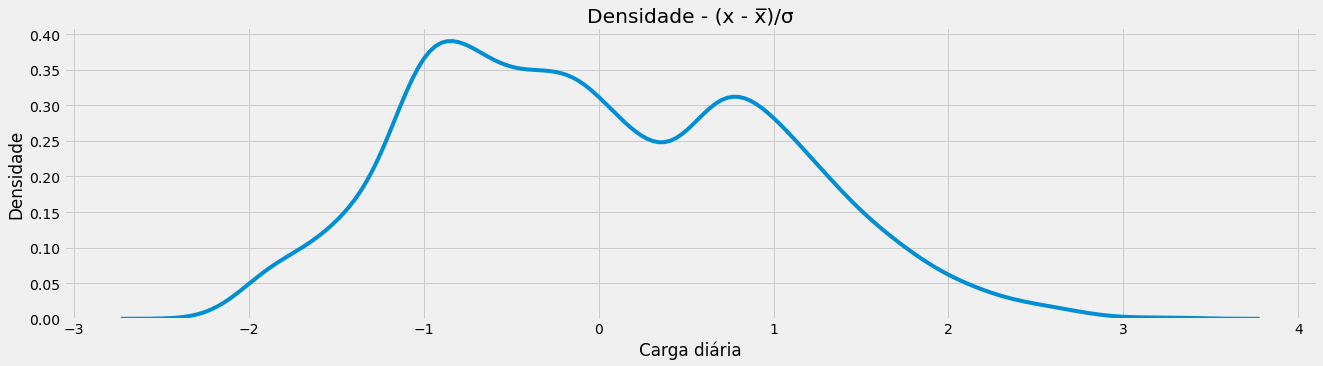

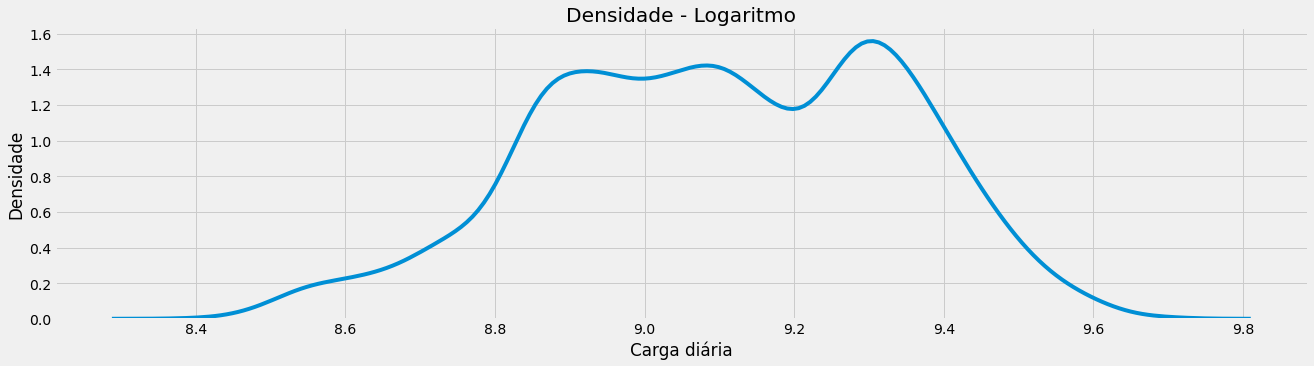

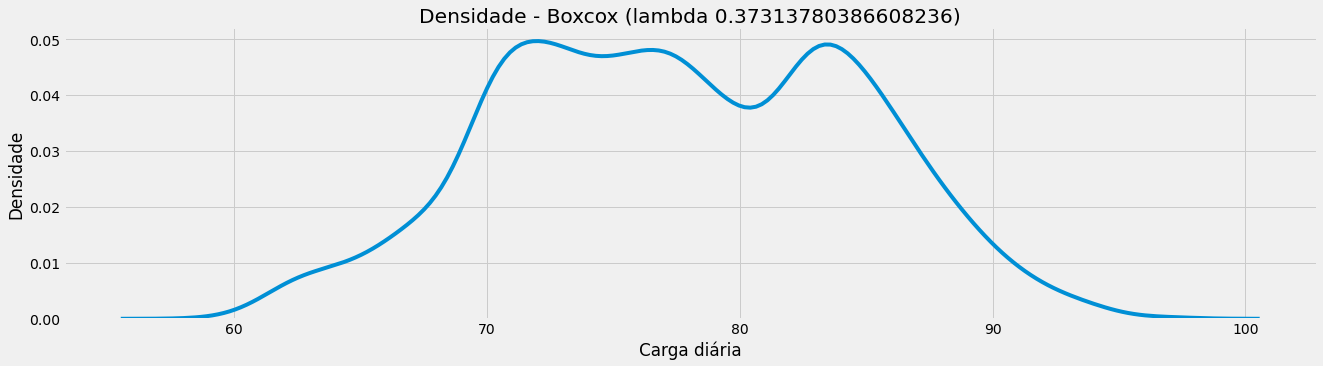

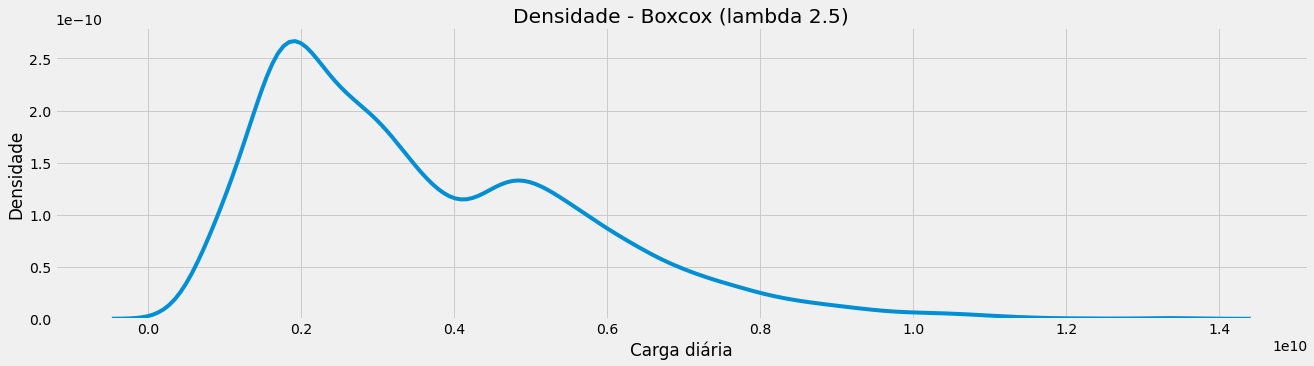

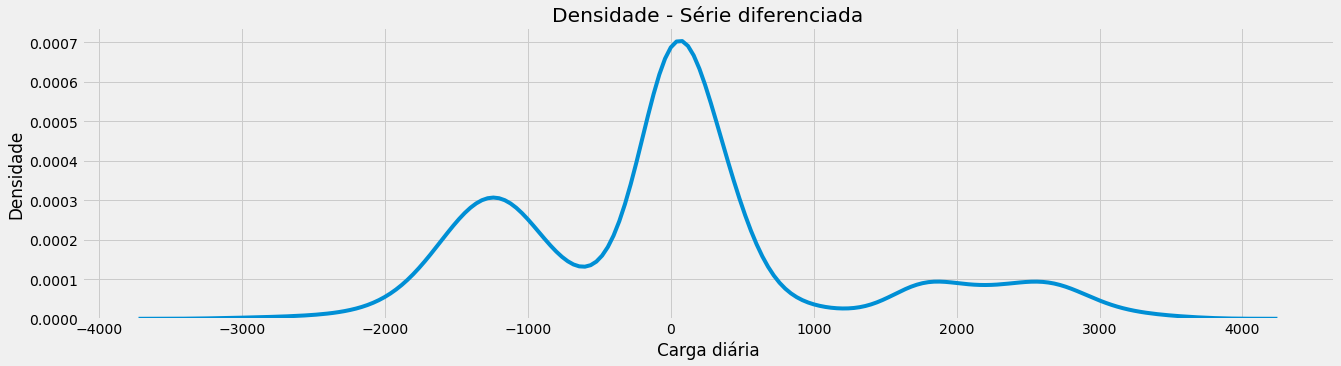

In [78]:
for nome, serie in series.items():
    plt.figure(figsize = (20, 5))
    sns.kdeplot(serie)
    plt.title(f"Densidade - {nome}")
    plt.ylabel(f"Densidade")
    plt.xlabel("Carga diária")
    plt.show()